In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
%matplotlib inline

In [16]:
import numpy as np
import pandas as pd

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fcs = nn.Sequential(
                    nn.Linear(22050, 10000),
                    nn.BatchNorm1d(10000),
                    nn.ReLU(True),
                    nn.Linear(10000, 4096),
                    nn.BatchNorm1d(4096),
                    nn.ReLU(True),
                    nn.Linear(4096, 1000),
                    nn.BatchNorm1d(1000),
                    nn.ReLU(True),
                    nn.Linear(1000, 140),
                )
    def forward(self, input_data):
        feature = self.fcs(input_data)

        return feature

In [11]:
def train(dataloader, net, criterion, optimizer, use_cuda=False):
    net.train() # Sets the module in training mode.

    batch_size = 128
    loss_sum = 0
    for batch_idx, (inputs, target) in enumerate(dataloader):
        if use_cuda:
            inputs, target = inputs.cuda(), target.cuda()
            
        optimizer.zero_grad()
        inputs, target = Variable(inputs), Variable(target)
        
        pred_target = net(inputs)
        

        loss = criterion(target, pred_target)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            loss_sum += loss.detach().cpu().numpy()
    
    return loss_sum

In [17]:
criterion = torch.nn.L1Loss()

net = Net()
use_cuda = False
if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    net.cuda()
    criterion = criterion.cuda()
    use_cuda = True
    
optimizer = optim.Adam(net.parameters(), lr=0.001) 

In [15]:
def Average(lst):
    return sum(lst) / len(lst)

In [19]:
epoch_loss_lst = []
for epoch in range (0, 60):
    loss_lst = []
    for i in range(0, 68):
        train_input = pd.read_hdf('./train_cite_inputs.h5', start= 1024 * i, stop=1024 * i + 1024)
        train_target = pd.read_hdf('./train_cite_targets.h5', start= 1024 * i, stop=1024 * i + 1024)
        x_train = train_input.to_numpy()
        y_train = train_target.to_numpy()
        x_train = torch.Tensor(x_train)
        y_train = torch.Tensor(y_train)

        train_dataset = TensorDataset(x_train, y_train)
        dataloader_source = DataLoader(train_dataset, shuffle = True, batch_size=128, drop_last=True)

        loss = train(dataloader_source, net, criterion, optimizer, use_cuda) 
        loss_lst.append(loss)
    epoch_loss = Average(loss_lst)
    epoch_loss_lst.append(epoch_loss)
    print("ep: %d, loss: %.2f" % (epoch, epoch_loss))

ep: 0, loss: 8.53
ep: 1, loss: 8.07


KeyboardInterrupt: 

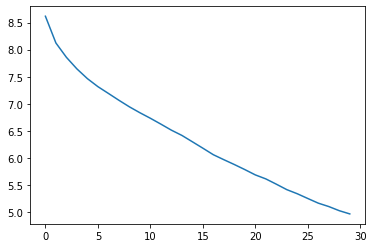

In [ ]:
plt.plot(range(0, 60), epoch_loss_lst)